<a href="https://colab.research.google.com/github/JunaHwang/JunaKaggleProject/blob/main/Kaggle_Project_Chest_X_Ray_Images_(Pneumonia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime
import cv2
import zipfile
import tarfile
import shutil
import os
import glob

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

- 오버피팅을 줄이면서 90% 이상의 정확도를 가지는 아키텍처 구현

## 경로 설정_colab

In [ ]:
ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia")

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")

## 데이터셋 가져오기_colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#### Colab
from google.colab import drive

drive.mount("/content/gdrive")

shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab Notebooks/", "Chest_Xray_Pneumonia.zip"),
            ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia.zip"), "r") as target_file:
    target_file.extractall(ROOT_DIR)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 정답 및 전체 데이터 갯수 확인

In [ ]:
#### 훈련 데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
# print(len(train_label_list))

for label_name in train_label_name_list:
    print("train label :", label_name, " => ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print("="*50)

#### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
# print(len(test_label_list))

for label_name in test_label_name_list:
    print("test label :", label_name, " => ",
         len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print("="*50)

#### VALIDATION 데이터 갯수
val_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)
# print(len(val_label_list))

for label_name in val_label_name_list:
    print("val label :", label_name, " => ",
         len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))

train label : PNEUMONIA  =>  3875
train label : NORMAL  =>  1341
test label : PNEUMONIA  =>  390
test label : NORMAL  =>  234
val label : PNEUMONIA  =>  8
val label : NORMAL  =>  8


### Image Shape 설정

In [ ]:
IMG_SIZE = 224 # colab : 224

### ImageDataGenerator 를 이용하여 데이터 불러오기

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode="rgb", class_mode="sparse",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                subset="training")

val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode="rgb", class_mode="sparse",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                subset="validation")

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode="rgb", class_mode="sparse",
                                                target_size=(IMG_SIZE, IMG_SIZE))

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [ ]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]
print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]


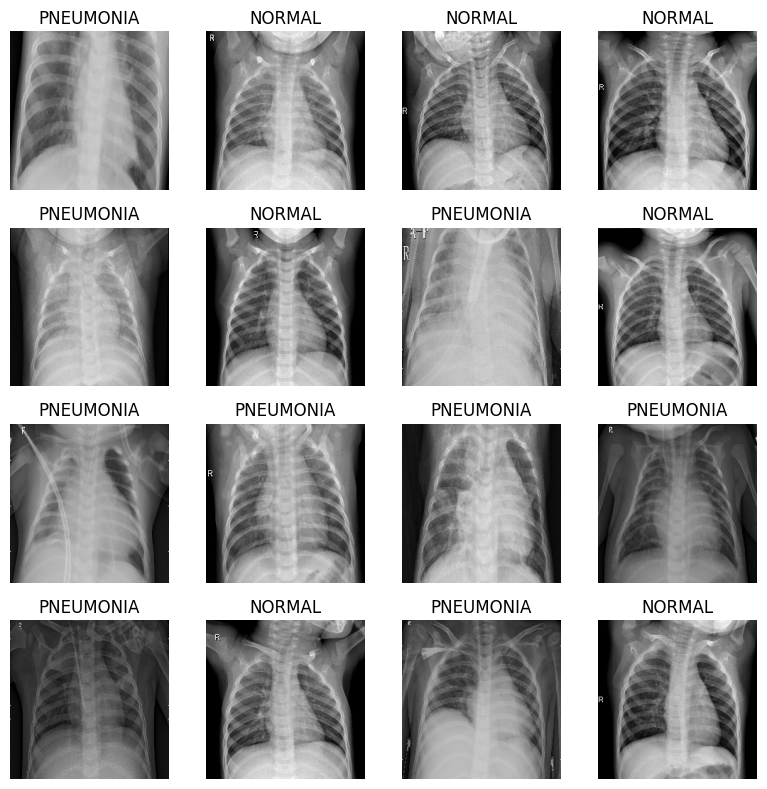

In [ ]:
plt.figure(figsize=(8, 8))

class_dict = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(len(label)):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [ ]:
pre_trained_model = InceptionV3(weights="imagenet",
                             include_top=False,
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_470 (Batch  (None, 111, 111, 32  96         ['conv2d_470[0][0]']             
 Normalization)                 )                                                      

In [ ]:
model = Sequential()

model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(2e-5), metrics=["acc"])

In [ ]:
start_time = datetime.now()

result = model.fit(train_generator, epochs=20,
                  validation_data=val_generator)

end_time = datetime.now()
print("Fit Start :", start_time)
print("Elapsed Time :", end_time-start_time)

Epoch 1/20
131/131 [==============================] - 116s 577ms/step - loss: 0.4823 - acc: 0.7242 - val_loss: 0.4160 - val_acc: 0.7430
Epoch 2/20
131/131 [==============================] - 79s 602ms/step - loss: 0.2263 - acc: 0.9001 - val_loss: 0.2413 - val_acc: 0.8993
Epoch 3/20
131/131 [==============================] - 71s 543ms/step - loss: 0.0818 - acc: 0.9784 - val_loss: 0.2801 - val_acc: 0.9185
Epoch 4/20
131/131 [==============================] - 71s 541ms/step - loss: 0.0416 - acc: 0.9885 - val_loss: 0.1610 - val_acc: 0.9492
Epoch 5/20
131/131 [==============================] - 72s 550ms/step - loss: 0.0273 - acc: 0.9921 - val_loss: 0.0710 - val_acc: 0.9760
Epoch 6/20
131/131 [==============================] - 71s 541ms/step - loss: 0.0131 - acc: 0.9974 - val_loss: 0.0615 - val_acc: 0.9808
Epoch 7/20
131/131 [==============================] - 71s 538ms/step - loss: 0.0122 - acc: 0.9959 - val_loss: 0.0538 - val_acc: 0.9866
Epoch 8/20
131/131 [==============================] - 

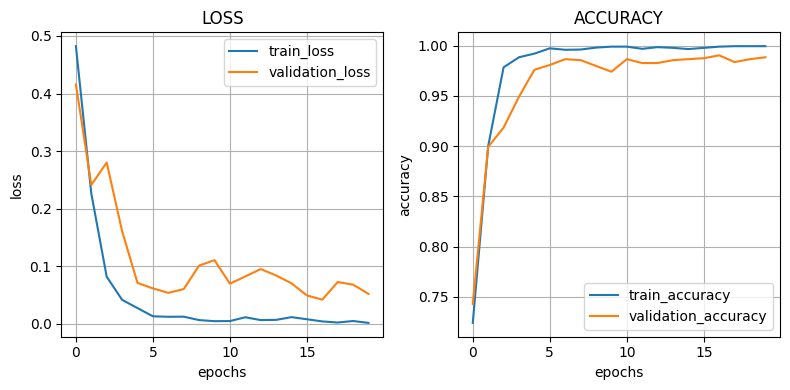

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["acc"], label="train_accuracy")
plt.plot(result.history["val_acc"], label="validation_accuracy")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_generator)

20/20 [==============================] - 7s 321ms/step - loss: 1.9338 - acc: 0.7788


[1.9338388442993164, 0.7788461446762085]

In [ ]:
model.evaluate(val_generator)

33/33 [==============================] - 14s 408ms/step - loss: 0.0520 - acc: 0.9885


[0.051975082606077194, 0.9884947538375854]

In [ ]:
test_simple_dataget = ImageDataGenerator(rescale=1./255)
test_simple_generator = train_data_gen.flow_from_directory(VALIDATION_DATA_ROOT_DIR,
                                                          batch_size=32,
                                                          color_mode="rgb",
                                                          class_mode="sparse",
                                                          target_size=(IMG_SIZE, IMG_SIZE))

Found 16 images belonging to 2 classes.


In [ ]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 238ms/step - loss: 0.9349 - acc: 0.8125


[0.9349098801612854, 0.8125]

In [1]:
## 데이터 리샘플링

In [ ]:
### 이동

### test, val -> train

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(test => train)")

# VAL
val_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)
print(val_label_name_list)

for label_name in val_label_name_list:
    val_path = os.path.join(VALIDATION_DATA_ROOT_DIR, label_name)
    val_file_list = os.listdir(val_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file),
                   os.path.join(train_path, val_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(validation => train)")

### move 완료된 Training 전체 데이터 수 확인

os.listdir("/content/Chest_Xray_Pneumonia/train")

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("train label : ", label_name,
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

### 분리

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR,label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR,label_name)
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)
    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name ,
                                                 len(train_data_file_list)))

    # data shuffle
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))
    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

['PNEUMONIA', 'NORMAL']
0 is moved into PNEUMONIA(test => train)
0 is moved into NORMAL(test => train)
['PNEUMONIA', 'NORMAL']
0 is moved into PNEUMONIA(validation => train)
0 is moved into NORMAL(validation => train)
['PNEUMONIA', 'NORMAL']
train label :  PNEUMONIA 4273
train label :  NORMAL 1583
total [PNEUMONIA] data file nums => [4273]
train data shuffle is done !!!
split nums =>  854
total move nums =>  854
total [NORMAL] data file nums => [1583]
train data shuffle is done !!!
split nums =>  316
total move nums =>  316


In [ ]:
## 데이터 이동 후 개수 재 확인

#### 훈련 데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
# print(len(train_label_list))

for label_name in train_label_name_list:
    print("train label :", label_name, " => ",
         len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print("="*50)

#### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
# print(len(test_label_list))

for label_name in test_label_name_list:
    print("test label :", label_name, " => ",
         len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print("="*50)

#### VALIDATION 데이터 갯수
val_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)
# print(len(val_label_list))

for label_name in val_label_name_list:
    print("val label :", label_name, " => ",
         len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))

train label : PNEUMONIA  =>  3419
train label : NORMAL  =>  1267
test label : PNEUMONIA  =>  854
test label : NORMAL  =>  316
val label : PNEUMONIA  =>  0
val label : NORMAL  =>  0


### Image Shape 설정

In [ ]:
IMG_SIZE = 224 # colab : 224

### ImageDataGenerator 를 이용하여 데이터 불러오기

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode="rgb", class_mode="sparse",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                subset="training")

val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode="rgb", class_mode="sparse",
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                subset="validation")

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32,
                                                color_mode="rgb", class_mode="sparse",
                                                target_size=(IMG_SIZE, IMG_SIZE))

Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [ ]:
pre_trained_model = InceptionV3(weights="imagenet",
                             include_top=False,
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_564 (Batch  (None, 111, 111, 32  96         ['conv2d_564[0][0]']             
 Normalization)                 )                                                      

In [ ]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# model.add(Dense(2, activation="softmax"))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_22 (Dense)            (None, 256)               524544    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               131584    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                      

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(2e-5), metrics=["acc"]) # colab lr=2e-5

In [ ]:
start_time = datetime.now()

result = model.fit(train_generator, epochs=20,
                  validation_data=val_generator)

end_time = datetime.now()
print("Fit Start :", start_time)
print("Elapsed Time :", end_time-start_time)

Epoch 1/20
118/118 [==============================] - 106s 572ms/step - loss: 0.5059 - acc: 0.7136 - val_loss: 0.5333 - val_acc: 0.7297
Epoch 2/20
118/118 [==============================] - 62s 522ms/step - loss: 0.2647 - acc: 0.8843 - val_loss: 0.5357 - val_acc: 0.7521
Epoch 3/20
118/118 [==============================] - 65s 549ms/step - loss: 0.1290 - acc: 0.9659 - val_loss: 0.3967 - val_acc: 0.8643
Epoch 4/20
118/118 [==============================] - 62s 525ms/step - loss: 0.0592 - acc: 0.9867 - val_loss: 0.2731 - val_acc: 0.9220
Epoch 5/20
118/118 [==============================] - 63s 537ms/step - loss: 0.0401 - acc: 0.9904 - val_loss: 0.2193 - val_acc: 0.9359
Epoch 6/20
118/118 [==============================] - 63s 535ms/step - loss: 0.0181 - acc: 0.9957 - val_loss: 0.1247 - val_acc: 0.9690
Epoch 7/20
118/118 [==============================] - 63s 533ms/step - loss: 0.0173 - acc: 0.9955 - val_loss: 0.1152 - val_acc: 0.9754
Epoch 8/20
118/118 [==============================] - 

In [ ]:
model.evaluate(test_generator)

37/37 [==============================] - 16s 423ms/step - loss: 0.2070 - acc: 0.9581


[0.20697391033172607, 0.9581196308135986]

In [ ]:
model.evaluate(val_generator)

30/30 [==============================] - 12s 407ms/step - loss: 0.1779 - acc: 0.9541


[0.17794077098369598, 0.9540598392486572]

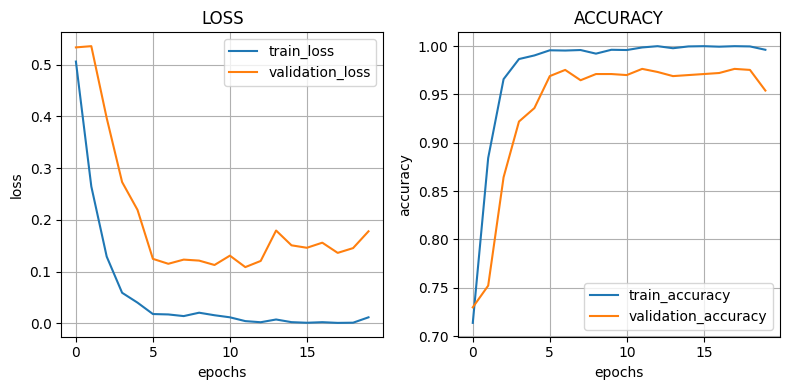

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["acc"], label="train_accuracy")
plt.plot(result.history["val_acc"], label="validation_accuracy")
plt.legend(loc="best")

plt.tight_layout()
plt.show()